In [78]:
from fpla.utils import load_config
import pandas as pd
import numpy as np
from pathlib import Path 
import sqlite3 
from itertools import islice

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

CONFIG_PATH = Path('../sources-config.json')

## FPL Player "Transfers" Model

Each team in Fantasy Premier League is made up of exactly 15 players. Throughout the season users can transfer players in/out of their team, which means the number of teams which "own" a particular player will fluctuate over time. 

The purpose of this model is to **predict how many teams will transfer a given player in the next gameweek** based on current and historical data. 


We start by loading our dataset which contains (for each gameweek in the 2017/18 season) the number of teams that selected each player (our dependent variable), and other variables which we will try to use as predictors in our model. 

In [2]:
config = load_config(CONFIG_PATH)
db_con = sqlite3.connect(config['db_connection'])

In [3]:
df = pd.read_sql('select * from fpl_player_2017', con=db_con)

# take only one match from "double" gameweeks as transfer stats are identical 
df = df.loc[(df.gw_match == 1)] 

### Data profiling 

In [4]:
df['player_id'].nunique() 

647

There are 641 players in our dataset. We will take a sample of the 50 players with the highest ownership, that is, the players which were selected most often on average across the 38 gameweeks in the season. We will also find the 50 least owned players. 

In [5]:
sorted_players = df.groupby('player_name').selected.median().sort_values().index

top_50 = sorted_players[-50:]
bottom_50 = sorted_players[:50]

In [6]:
def plot_distribution(df, player_filter):
    plt.figure(figsize=(10,15))
    
    df_filtered = df.loc[df.player_name.isin(player_filter)]
    
    colour_map = {'g':'grey', 'd':'royalblue', 'm':'darkorange', 'f':'limegreen'} 
    colours = df.groupby('player_name').pos.max().map(colour_map).to_dict() 

    sns.boxplot(x='selected', y='player_name', data=df, orient='h', order=player_filter, palette=colours) 

Plotting the distribution of our dependent variable `selected`, for each player in our "most owned" sample. `selected` is the number of teams which owned a player in a given gameweek. 

Boxes have been coloured by player position:
* Goalkeeper (grey) 
* Defender (blue) 
* Midfielder (orange) 
* Forward (green) 

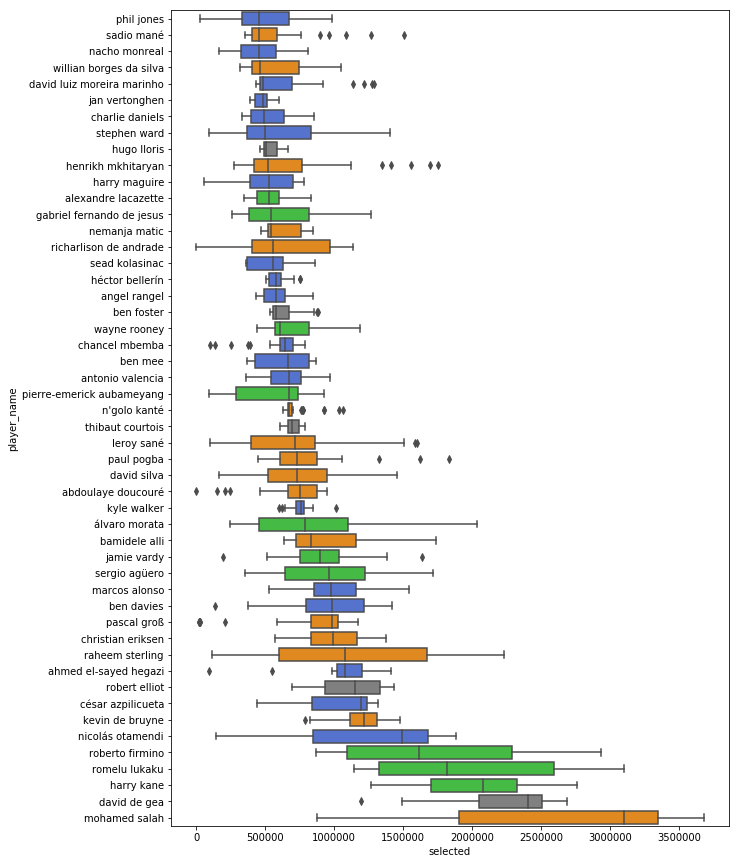

In [7]:
plot_distribution(df, player_filter=top_50)

Looking at the distribution of `selected` gives us a lot of insight into the sort of season a player has had. 

We will compare Manchester City midfielders **Raheem Sterling** and **Kevin De Bruyne**. 
Both players had outstanding seasons, breaking the 200 points barrier and ending up with a similar ownership average. But the distribution above suggests two very different journeys, and we will check this by plotting `gw` (gameweek) vs. `selected` to see their ownership history. 

In [8]:
dfp = df.pivot(index='gw', columns='player_name', values='selected')

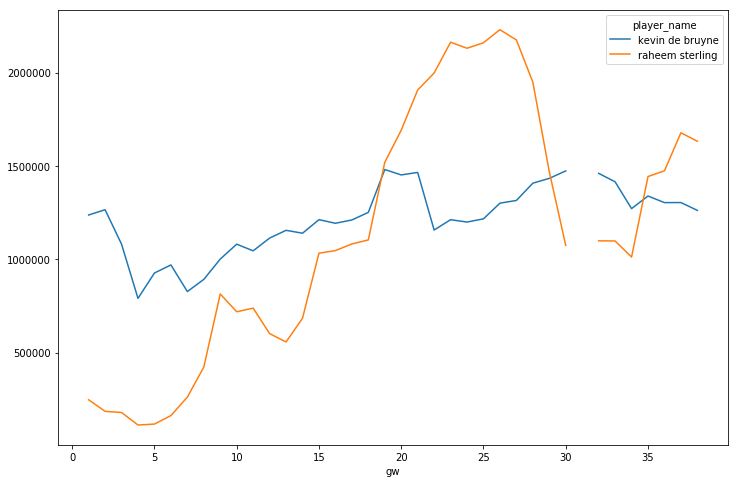

In [9]:
(dfp.loc[:, ['kevin de bruyne', 'raheem sterling']]
    .plot(figsize=(12, 8)))

plt.show()

Both players show clear trends which we could hope to capture with a univariate time series forecast (e.g. an ARIMA model using historical `selected`to predict future `selected`). However any response to changes in direction would be delayed (as it would take a few samples for the model to "notice"), and the overall short length of the series (max 38 samples) means that fitting a single model per player is not likely to yield great results. 

To try and capture the intricacies shown above we will instead combine all series in to a "single input", and included other features as predictors (in addition to lagged versions of `selected`). 

Looking further at this example, **De Bruyne** is the quintessential "steady" option, tried and tested across the years his ownership started high, and slowly gained* as the season progressed. 

In contrast, **Sterling's** hot/cold historical form attracted a much smaller initial population, which was compounded by not making the starting XI in early gameweeks, and a red card suspension. 

However that dramatically turned around as he emerged a consistent threat, and his cheaper price led to him eventually eclipsing the more expensive **De Bruyne**. That was curtailed in GW27 following an injury, but once recovered, so did his ownership. 

Just from this example we are already seeing *short term form*, *long term form*, *price* and *injury status* as factors affecting the selection of a player.

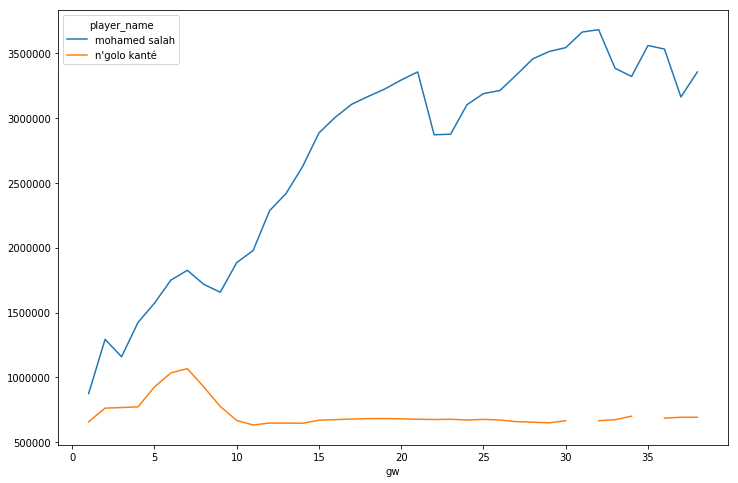

In [10]:
(dfp.loc[:, ["mohamed salah", "n'golo kanté"]]
    .plot(figsize=(12, 8)))

plt.show()

Next up we compare "The King of Egypt" himself **Mohamed Salah** with "The King of Interceptions" **N'golo Kanté**. 

Already a popular pick in GW1, **Salah's** stratospheric rise can be attributed to his record-breaking season in front of goal. Whilst his ownership almost exclusively *increases* over time, there is a slowdown towards the end of the season. As his form was pretty much relentless, this could be due to him reaching a "saturation", in ownership with the majority of teams that would want to own him, already owning him. With a peak ownership of 3.5m (out of a possible ~6m teams), and many teams dead in the water at that late stage in the season (making no changes in selection) this "grass ceiling" seems a real possibility. 

Another explanation could be that his inevitable increase in price lead to reduction in his attractiveness as a transfer option.  Meanwhile the small dips in later weeks are likely due to his team not playing any "double gameweeks" (more on this later), despite having favourable fixtures. 

If **Salah's** goals were worthy of winning a Premier League title, there is no denying that **Kanté's** contribution to his teams in the previous two seasons *did* result in back-to-back titles. 

However from an FPL standpoint he sits in the least attractive of all the positions: defensive midfield. This means that his relatively high ownership can be explained almost entirely by his cheap-as-chips price point. But the thing that really stands out in the distribution plot is the sheer consistency in ownership. He is considered to be a classic *5th midfielder* which means he spends the majority of the season sitting on the bench of an FPL team, simply there to enable funds for higher scoring players. As he was rarely injured is is unlikely that teams would waste a transfer getting rid of him for a similarly cheap player. 

There were however a couple of spikes in **Kanté** ownership with a rare goal in the opening gameweeks, and a more subtle increase in GW34 as Chelsea played two games in a "double gameweek". 

We see in this comparison the need to also capture the *stage in a season*, *fixtures*, *player position* and other reasons for *player price* as factors affecting ownership. 

We will now consider the distribution of the least owned players in the league. 

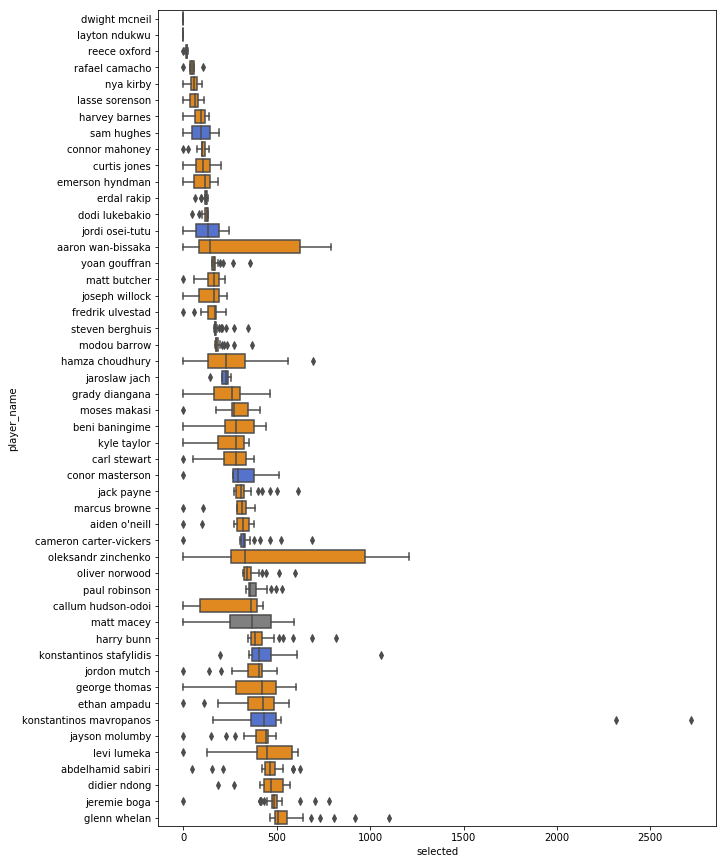

In [11]:
plot_distribution(df, player_filter=bottom_50)

The vast majority of these players are cheap "enablers" which sit on the bench, but we would like to be able to predict their ownership accurately nonetheless. The contrast in level of ownership of these players vs. the most popular players (hundreds compared to millions) means we need to careful consideration when we come to train our model. 

One player that enjoyed a few weeks as an outlier was Arsenal's **Konstantinos Mavropanos**. Defensive injuries lead to him making a few starts and picking up a clean sheet in the process. This kicked off a (relative) frenzy of transfers with many more teams selecting him. Unfortunately just as his *bandwagon* was starting to gain momentum in his third appearance ended up shorter than his name, as he was sent off.

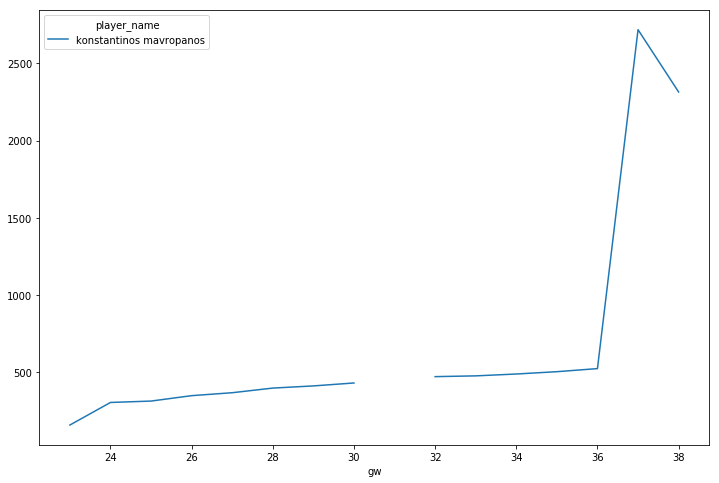

In [12]:
(dfp.loc[:, ["konstantinos mavropanos"]]
    .plot(figsize=(12, 8)))

plt.show()

We will now plot the ownership of *all* players in the top 50.

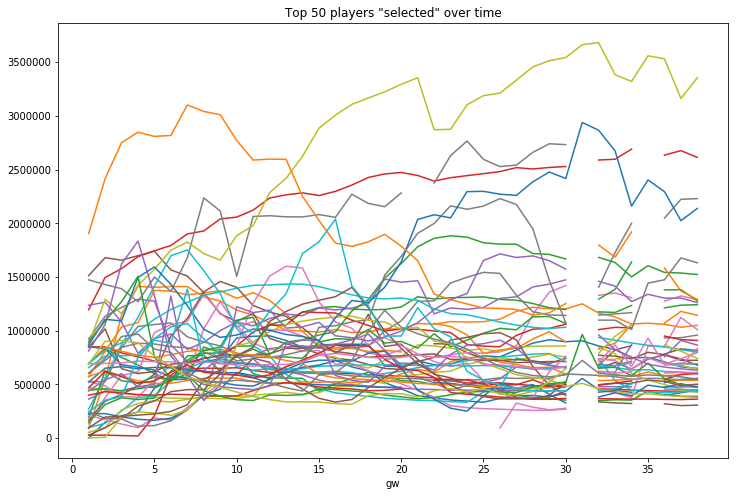

In [13]:
(dfp.loc[:, dfp.columns.isin(top_50)]
    .plot(figsize=(12, 8), legend=False, title='Top 50 players "selected" over time')) 

plt.show()

We notice a few things here:
1. There are gaps for some players in GW20, GW31 and GW34. This is due to missing data for players which do not have a fixture in a particular gameweek, despite still being owned in that gameweek. This is particularly dissapointing as these cases where players have no fixtures are quite interesting from an ownership standpoint, with the players that do play seeing an obvious increases in `selected`. We may decide later on to drop these gameweeks altogether for consistency. 
2. Less noticeable but there is a general upward trend in `selected` as `gw` increases at the start of the season. This is discussed later. 
3. There are several players which do not appear to have their history starting GW1. This is more noticeable on the plot of the bottom 50 players below. 

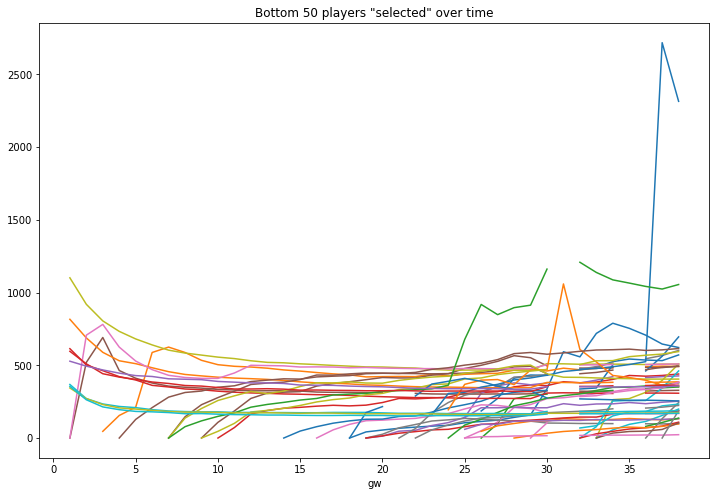

In [14]:
(dfp.loc[:, dfp.columns.isin(bottom_50)]
    .plot(figsize=(12, 8), legend=False, title='Bottom 50 players "selected" over time')) 

plt.show()

We can explain points [2] and [3] above by looking at the average `selected` across all players 

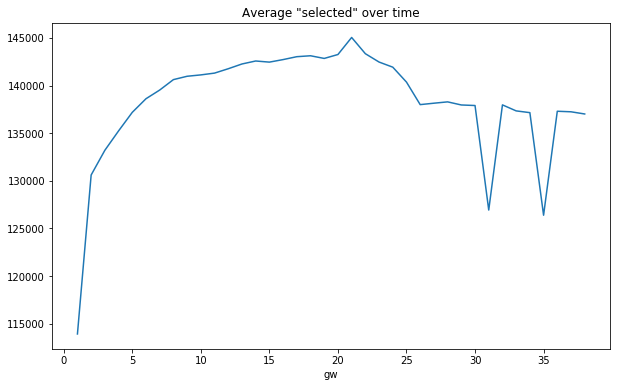

In [15]:
(df.groupby('gw').selected.mean()
    .plot(figsize=(10, 6), legend=False, title='Average "selected" over time')) 

plt.show()

We see an initial increase in average ownership followed by a decrease over the course of the season. The extreme dips are due to our missing data. We can explain the trends better by separating the numerator (sum of `selected` players) and the denominator (number of distinct `player_id`) 

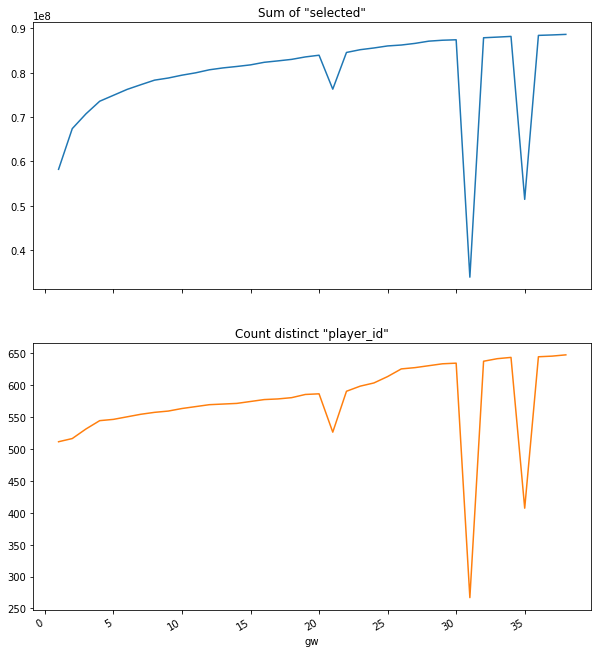

In [16]:
(df.groupby('gw').aggregate({'selected':'sum', 'player_id':'nunique'})
   .plot(figsize=(10, 12),
         legend=False,
         subplots=True, 
         title=['Sum of "selected"', 'Count distinct "player_id"']))

plt.show()

There is an initial surge of `selected` caused by many FPL users submitting their team after the GW1 deadline. This continues throughout the season at a slower rate. This explains point [2] above. 

However at the same time the number of players available to pick from is increasing (which dilutes the average). This eventually becomes the dominant term, causing the overall drop in average. There are two ways in which a player can be added to the FPL game:
1. New signing into the Premier League, notice the bump around week 26 at the end of the January transfer window
2. Existing player promoted into the first team

This explains point [3] above. 

Also note that players are not removed from the FPL game during the season (even if they leave the Premier League), so we always expect an increase in the second plot. 

The distribution of number of weeks of available history is shown below wgereywe can again see a bump in players available for ~15 weeks due to the transfer window. 

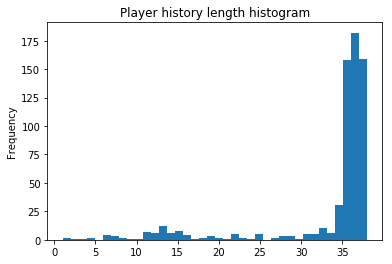

In [17]:
(df.groupby('player_name')
   .size()
   .plot(kind='hist', bins=38, title='Player history length histogram'))

plt.show()

###  Data summary

1. **Missing data for players with no fixtures** This should not be a significant problem but is not ideal. We may want to consider dropping all gameweeks with missing fixtures is we find model is not effective. Next season we can get weekly snapshot to collect a full history. 
2. **Varying number of FPL teams** As we are using `selected` as a raw counts there will be a subtle upwards trend which we cannot capture as we do not have the actual number of teams available. If we did we could express selected as a percentage. 
3. **Not all players have a full history** This is not a missing data issue as some players genuinely do not exist for the whole season, but it may cause issues when creating lag variables. May want to consider setting a minimum history. 